In [ ]:
!pip install torch pandas matplotlib scikit-learn yfinance

In [ ]:
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# import matplotlib
import math
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# Define the list of NSE stock symbols with the .NS suffix
nse_stocks = ['ACC.NS'] #INFY
start_date = "2018-01-01"
end_date = datetime.now()#"2024-09-01"
# Fetch the stock data (historical data for a given date range)
stock_data = yf.download(nse_stocks, start=start_date, end=end_date)
print("\n")
print(stock_data.head())
filtered_data=stock_data.filter(['Close'])
filtered_data.reset_index(inplace=True)
filtered_data.head()


[*********************100%***********************]  1 of 1 completed



                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2018-01-01  1763.949951  1763.949951  1725.000000  1731.349976  1573.853882   
2018-01-02  1736.199951  1745.800049  1725.000000  1743.199951  1584.625732   
2018-01-03  1741.099976  1780.000000  1740.099976  1774.599976  1613.169556   
2018-01-04  1779.949951  1808.000000  1770.000000  1801.349976  1637.486206   
2018-01-05  1801.099976  1820.400024  1795.599976  1809.949951  1645.303955   

            Volume  
Date                
2018-01-01  123565  
2018-01-02  277110  
2018-01-03  194666  
2018-01-04  278240  
2018-01-05  312489  


,Date,Close
0,2018-01-01,1731.349976
1,2018-01-02,1743.199951
2,2018-01-03,1774.599976
3,2018-01-04,1801.349976
4,2018-01-05,1809.949951


In [ ]:
# stock_data=pd.read_csv("ACC.csv")
# stock_data["Date"]=pd.to_datetime(stock_data["Date"])
# # start_date = stock_data["Date"].min()
# # end_date = stock_data["Date"].max()
# start_date = "2012-01-01"
# end_date = "2021-01-01"
# filtered_data=stock_data.loc[(stock_data["Date"]>=start_date) & (stock_data["Date"]<=end_date),["Date","Close"]]
# filtered_data.reset_index(drop=True,inplace=True)
# filtered_data.head()

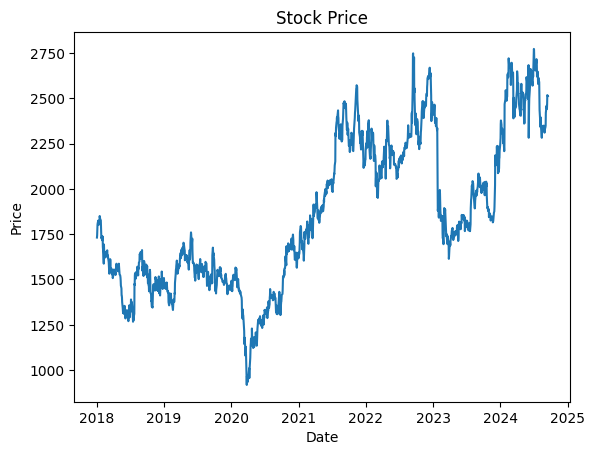

In [ ]:
plt.title("Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(filtered_data.Date,filtered_data['Close'])

In [ ]:
filtered_data.info()
print("check nulll values")
print(filtered_data.isnull().any())
if filtered_data["Close"].isnull().any():
    filtered_data["Close"].fillna(method='ffill', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1655 entries, 0 to 1654
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1655 non-null   datetime64[ns]
 1   Close   1655 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.0 KB
check nulll values
Date     False
Close    False
dtype: bool


**MinMaxScaler (Most common):**

Use case: This scaler is widely used for stock price prediction, especially when using models like LSTM, RNNs, or GRUs, because it normalizes the data within a specific range (usually [0, 1] or [-1, 1]), which is suitable for models sensitive to large variations in data.
Pros: Preserves the shape of the distribution and handles data within a fixed range.

**StandardScaler:**

Use case: If your data is **normally distributed**, StandardScaler may work better, as it scales the data to have zero mean and unit variance.
Pros: Works well if you expect the data to be centered around a mean and normally distributed.

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
#  MinMaxScaler (or any scaler from sklearn) expects a 2D array as input. filtered_data["Close"].values is 1D array
filtered_data["Close"]=scaler.fit_transform(filtered_data["Close"].values.reshape(-1,1))

In [ ]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []

    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(filtered_data.loc[:,["Close"]], look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1276, 59, 1)
y_train.shape =  (1276, 1)
x_test.shape =  (319, 59, 1)
y_test.shape =  (319, 1)


In [ ]:
# make training and test sets in torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)

Using device: cuda


In [ ]:
y_train.size(),x_train.size()

(torch.Size([1276, 1]), torch.Size([1276, 59, 1]))

**self.fc=nn.Linear(hidden_neurons,output_dim)**

The Linear layer, also known as a fully connected layer, is used to transform the output from the LSTM into the desired output shape. In the context of time series forecasting or sequence prediction, it serves as the final layer that converts the LSTM's output to predictions.

**What Does .detach() Do?**

**Purpose:** The .detach() method creates a new tensor that shares the same data but does not require gradients. This new tensor is not part of the computation graph, meaning operations on it will not be tracked for gradient computation.

**Use Case:** This is useful when you want to prevent certain tensors from contributing to the gradient calculations in subsequent steps. It can be particularly relevant for managing memory and avoiding unnecessary gradient computations during training.

**Why Use the Last Time Step?**  

In many sequence processing tasks, especially when predicting a single value or class label for the entire sequence, you typically use the output from the last time step. This is because the last time step often contains the aggregated information from the entire sequence, capturing the final context or state learned by the LSTM.

**Summary**

  * **out[:, -1, :]:** Extracts the hidden state from the last time step of the sequence for each batch.

* **self.fc(out[:, -1, :]):** Applies a linear transformation to this last time step output to produce the final output, which might be used for tasks such as classification or regression.

  This approach allows you to leverage the LSTM's ability to capture temporal dependencies and make predictions based on the learned representation from the entire sequence.



In [ ]:
# Build model
input_dim = 1
hidden_neurons = 32
num_layers = 2
output_dim = 1
learning_rate = 0.01

# Orthogonal Initialization is generally recommended for LSTMs due to its ability to maintain stability and address issues with gradients.
def orthogonal_init(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

class LSTM(nn.Module):
  def __init__(self,input_dim,hidden_neurons,num_layers,output_dim):
      super(LSTM,self).__init__()
      # Hidden dimensions
      self.hidden_neurons = hidden_neurons

      # Number of hidden layers
      self.num_layers = num_layers

      # batch_first=True causes input/output tensors to be of shape
      # (batch_dim, seq_dim, feature_dim)
      self.lstm=nn.LSTM(input_dim,hidden_neurons,num_layers,batch_first=True,dropout=0.3) # num_layers >1 is Stacked LSTM #dropout=0.2
      # self.lstm.apply(orthogonal_init)  #use when you want
      self.fc=nn.Linear(hidden_neurons,output_dim)

  def forward(self, x):
      # Initialize hidden state with zeros
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_neurons).requires_grad_().to(x.device)

      # Initialize cell state
      c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_neurons).requires_grad_().to(x.device)

      # We need to detach as we are doing truncated backpropagation through time (BPTT)
      # If we don't, we'll backprop all the way to the start even after going through another batch
      out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

      # Index hidden state of last time step
      # out.size() --> 100, 32, 100 (batch_dim, seq_dim, feature_dim)
      # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
      out = self.fc(out[:, -1, :])
      # out.size() --> 100, 10

      return out

model = LSTM(input_dim=input_dim, hidden_neurons=hidden_neurons, output_dim=output_dim, num_layers=num_layers)
model.to(device)
loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate) #weight_decay=0.0001 L2 regularization strength
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [ ]:
# Train model
num_epochs = 100
hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    # model.hidden = model.init_hidden() does indeed reset the hidden state, making the model forget previous information .

    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.020459385588765144
Epoch  20 MSE:  0.010514342226088047
Epoch  30 MSE:  0.006945034489035606
Epoch  40 MSE:  0.0058835335075855255
Epoch  50 MSE:  0.005256967153400183
Epoch  60 MSE:  0.004766759462654591
Epoch  70 MSE:  0.004504974465817213
Epoch  80 MSE:  0.004123173654079437
Epoch  90 MSE:  0.003964322619140148


In [ ]:
# # early stop
# num_epochs = 100
# patience = 20  # Number of epochs to wait for improvement before stopping
# best_val_loss = float('inf')
# epochs_no_improve = 0
# early_stop = False

# train_losses = []
# val_losses = []

# for t in range(num_epochs):
#     model.train()
#     # Forward pass for training
#     y_train_pred = model(x_train)
#     train_loss = loss_fn(y_train_pred, y_train)
#     train_losses.append(train_loss.item())

#     # Zero out gradient, else they will accumulate between epochs
#     optimiser.zero_grad()

#     # Backward pass
#     train_loss.backward()

#     # Update parameters
#     optimiser.step()

#     # Validation
#     model.eval()
#     with torch.no_grad():
#         y_val_pred = model(x_test)
#         val_loss = loss_fn(y_val_pred, y_test)
#         val_losses.append(val_loss.item())

#     if t % 10 == 0:
#         print(f"Epoch {t}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

#     # Early stopping
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         epochs_no_improve = 0
#         # Save the model
#         torch.save(model.state_dict(), 'best_model.pth')
#     else:
#         epochs_no_improve += 1

#     if epochs_no_improve == patience:
#         print(f'Early stopping triggered at epoch {t}')
#         early_stop = True
#         break

#     if early_stop:
#         break

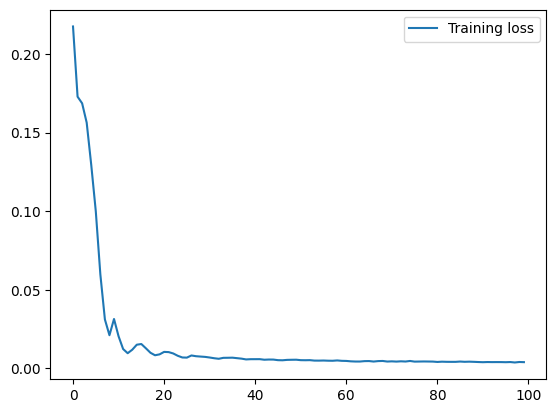

In [ ]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [ ]:
np.shape(y_train_pred)

torch.Size([1276, 1])

**Why Do You Need detach() Here?**

**Inference**: During inference (like evaluating your model on test data), you don't need gradients or to track how the data flows through the network. You're just making predictions, so detach() prevents unnecessary memory use.

**Memory Efficiency:** By detaching, you free up memory that would otherwise be used for storing information required for backpropagation, like gradients and the computation graph.

In [ ]:
model.eval()

with torch.no_grad():# prevents gradient calculations during inference.
    y_train_pred = model(x_train).cpu().numpy()
    y_test_pred = model(x_test).cpu().numpy()

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_train = scaler.inverse_transform(y_train.cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test = scaler.inverse_transform(y_test.cpu().numpy())

# for cpu
# y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
# y_train = scaler.inverse_transform(y_train.detach().numpy())
# y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
# y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 49.73 RMSE
Test Score: 63.14 RMSE


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# R-squared
r2 = r2_score(y_train[:,0], y_train_pred[:,0])
print('R-squared:(train) %.2f' % (r2))
r2_test = r2_score(y_test[:,0], y_test_pred[:,0])
print('R-squared:(test) %.2f' % (r2_test))


R-squared:(train) 0.98
R-squared:(test) 0.96


**Avoid overfitting** :

**Dropout:** Apply to LSTM layers to prevent co-adaptation of neurons.

**L2 Regularization (Weight Decay):** Penalize large weights in the model.

**Gradient Clipping:** Stabilize training by preventing exploding gradients.

**Early Stopping:** Stop training when validation performance stops improving.

**Sequence Length Regularization:** Adjust sequence length to reduce overfitting.

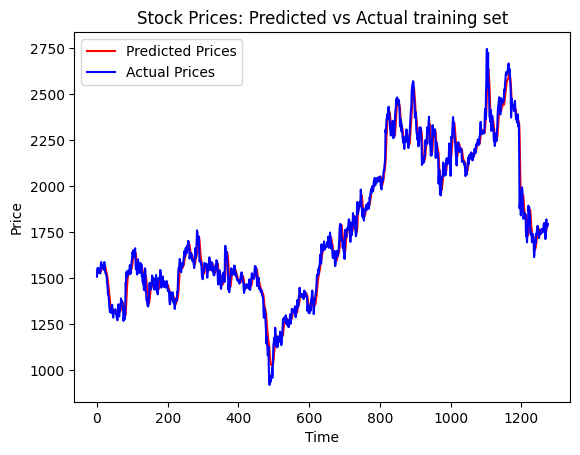

In [ ]:
# Plotting the predicted prices
plt.plot(y_train_pred, label='Predicted Prices', color='red')

# Plotting the actual prices
plt.plot(y_train, label='Actual Prices', color='blue')

# Adding titles and labels
plt.title('Stock Prices: Predicted vs Actual training set')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# Display the plot
plt.show()

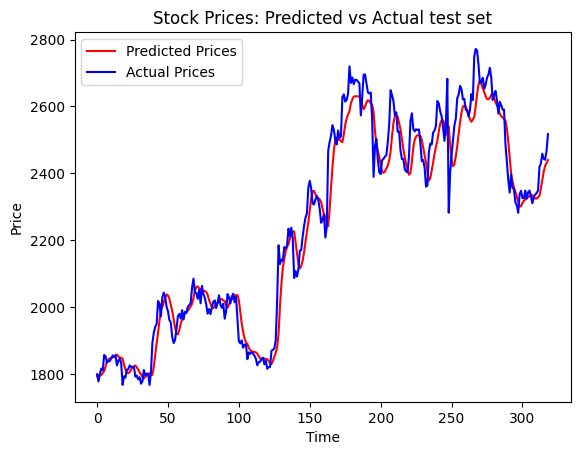

In [ ]:
# Plotting the predicted prices
plt.plot(y_test_pred, label='Predicted Prices', color='red')

# Plotting the actual prices
plt.plot(y_test, label='Actual Prices', color='blue')

# Adding titles and labels
plt.title('Stock Prices: Predicted vs Actual test set')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# Display the plot
plt.show()

In [ ]:
# Save the entire model
torch.save(model, 'model.pth')

In [ ]:
# Load the entire model
model = torch.load('model.pth',weights_only=False)
model = model.to(device)
# Set the model to evaluation mode if needed
model.eval()

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)